In [1]:
import numpy as np
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

import corner
import matplotlib as mpl

In [2]:
plt.rcdefaults()
fontsize = 14
from matplotlib import font_manager
from matplotlib import rcParams
from matplotlib import rc

cmfont = font_manager.FontProperties(fname=mpl.get_data_path() + '/fonts/ttf/cmr10.ttf')
plt.rcParams['font.serif']=cmfont.get_name()
params = {"ytick.color" : "black",
          "xtick.color" : "black",
          "axes.labelcolor" : "black",
          "axes.edgecolor" : "black",
          "font.size" : 16,#fontsize,
          "text.usetex" : True,
          "mathtext.fontset" : "cm",
          "font.family" : "serif",
          "font.serif" : [cmfont.get_name()],
          "text.latex.preamble" : r"\usepackage{amsmath}"}
plt.rcParams['axes.unicode_minus']=False
plt.rcParams.update(params)

In [3]:
def read_cov(fname):
    cov = np.genfromtxt(fname, delimiter = ',')
    eig, ev = np.linalg.eig(np.linalg.inv(cov))
    
    if not np.all(eig > 0):
        ind = np.where(eig < 0)[0][0]
        eig[ind] = 1e-6
        hes = ev.dot(np.diag(eig).dot(ev.T))
        cov = np.linalg.inv(hes)
        
    return cov


def gen_cov_ck(cov):
    hes = np.linalg.inv(cov)
    hes[[0,1]] = hes[[1,0]]
    hes[:,[0,1]] = hes[:,[1,0]]
    
    inv_cov_ck = np.zeros((9,9))
    inv_cov_ck[:5,:5] = hes[1:6,1:6]
    
    inv_cov_ck[7,:5] = hes[0,1:6]
    inv_cov_ck[:5,7] = hes[0,1:6]
    
    inv_cov_ck[7,8] = hes[0,6]
    inv_cov_ck[8,7] = hes[0,6]
    
    inv_cov_ck[8,:5] = hes[6, 1:6]
    inv_cov_ck[:5,8] = hes[6, 1:6]
    
    inv_cov_ck[7,7] = hes[0,0]
    inv_cov_ck[8,8] = hes[6,6]
    return inv_cov_ck


def err_v_tau(i):
    
    cov = read_cov(f'../data/cov_ck_a2_t1_plot_{i}.csv')
    inv_cov_ck = gen_cov_ck(cov)

    cov_spec = read_cov(f'../data/cov_spec_a2_t1_plot_{i}.csv')#, delimiter = ',')
    
    inv_cov_sp = np.zeros((9,9))
    inv_cov_sp[:7,:7] = np.linalg.inv(cov_spec)
    
    cov_tot = np.linalg.inv(inv_cov_ck + inv_cov_sp)# - np.eye(9)*1e-1)
    return [np.sqrt(np.diag(cov_tot))[0], np.sqrt(np.diag(cov_tot))[1]]

In [4]:
err = [err_v_tau(i) for i in range(1, 4)]

In [5]:
v_ar = [6e3, 4e3, 3e3]
tau_ar = [2,4.5,8]
t_ar = [30,45,60]

v_err = [[(1-np.exp(-1*err[i][0]))*v_ar[i] for i in range(3)],
         [(np.exp(err[i][0])-1)*v_ar[i] for i in range(3)]]

tau_err = [[(1-np.exp(-1*err[i][1]))*tau_ar[i] for i in range(3)],
          [(np.exp(err[i][1])-1)*tau_ar[i] for i in range(3)]]

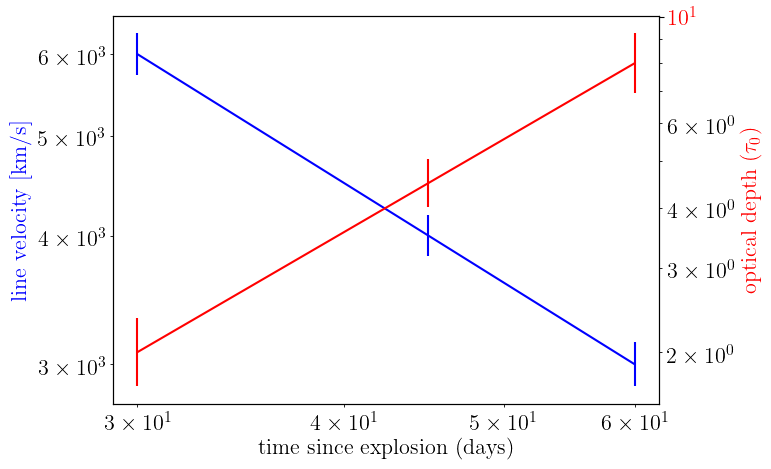

In [6]:
# Generate sample data
x = t_ar
y1 = v_ar  # Data for left y-axis (larger scale)
y2 = tau_ar  # Data for right y-axis (smaller scale)

# Create figure and primary axis
fig, ax1 = plt.subplots(figsize=(8, 5))

# Plot first line with left axis (in blue)
line1 = ax1.errorbar(x, y1, yerr = v_err, color='blue', label='Left axis data')
ax1.set_xlabel('time since explosion (days)')
ax1.set_ylabel('line velocity [km/s]', color='blue')
ax1.set_yscale('log')
ax1.tick_params(axis='y', labelcolor='blue')

# Create second y-axis sharing same x-axis
ax2 = ax1.twinx()

# Plot second line with right axis (in red)
line2 = ax2.errorbar(x, y2, yerr = tau_err, color='red', label='Right axis data')
ax2.set_ylabel(r'optical depth ($\tau_0$)', color='red')
ax2.set_yscale('log')
ax2.tick_params(axis='y', labelcolor='red')


# Add title
#plt.title('Dual Axis Plot with Different Scales')

# Adjust layout to prevent label cutoff
plt.tight_layout()

#plt.legend()
plt.xscale('log')
#plt.savefig('tau_v.pdf', bbox_inches = 'tight')